In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.formula.api import ols
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima

In [9]:
#importing the data

LAC_standardized_means = pd.read_csv('/Users/taylo/Downloads/envanalysis/group1-project/LAC_standardized_means.csv')


'Unnamed: 0'

In [25]:
#convert data so its ready to be usable in time series analysis

LAC_ready = LAC_standardized_means.rename(columns = {'Unnamed: 0' : 'Years', '0' : 'Standardized Mean'})

LAC_ready['Years'] = pd.to_datetime(LAC_standardized_means['Years'], format='%Y')

LAC_ready = LAC_ready.set_index('Years')


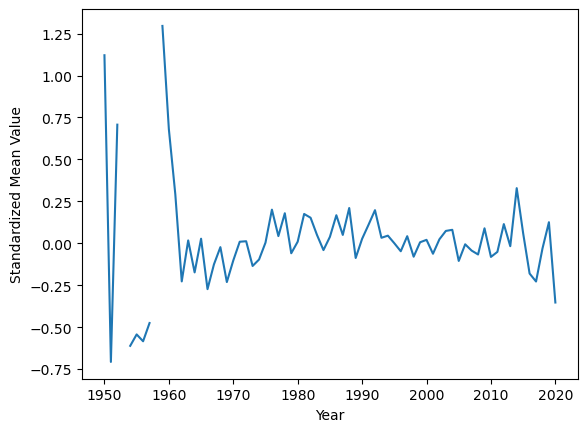

In [27]:
fig, ax = plt.subplots()
ax.plot(LAC_ready['Standardized Mean'])
ax.set_xlabel('Year')
ax.set_ylabel('Standardized Mean Value');

The standard mean value we are using for the time series analysis seems to be relatively constant, besides from the strange outliers in the early years

Autocorrelation and Stationarity do not allow NaN values, so for the following tests I made a new dataset where I deleted the years with NaN values (1953 and 1958)

In [40]:
LAC_noNaN = pd.read_csv('/Users/taylo/Downloads/envanalysis/group1-project/LAC_standardized_means_noNaN.csv')


LAC_noNaN = LAC_noNaN.rename(columns = {'Unnamed: 0' : 'Years', '0' : 'Standardized Mean'})

LAC_noNaN['Years'] = pd.to_datetime(LAC_noNaN['Years'], format='%Y')

LAC_noNaN = LAC_noNaN.set_index('Years')


,Standardized Mean
Years,
1950-01-01,1.120897
1951-01-01,-0.707107
1952-01-01,0.707107
1954-01-01,-0.611246
1955-01-01,-0.543236
...,...
2016-01-01,-0.180217
2017-01-01,-0.227834
2018-01-01,-0.030940


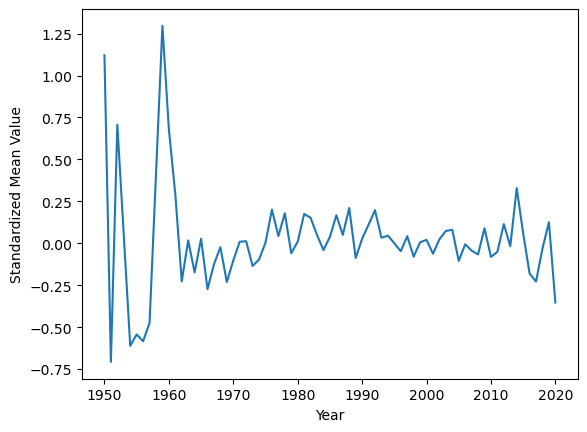

In [43]:
fig, ax = plt.subplots()
ax.plot(LAC_noNaN['Standardized Mean'])
ax.set_xlabel('Year')
ax.set_ylabel('Standardized Mean Value');

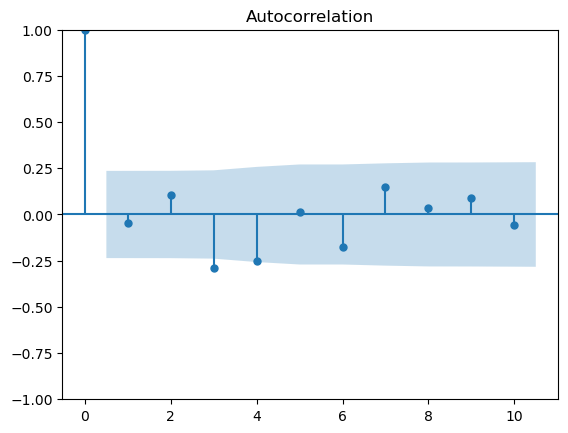

In [54]:
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(LAC_noNaN, lags=10);

In [41]:
#investigating autocorrelation

from scipy.stats import pearsonr

lag = 1

# current year

LAC_t = LAC_noNaN['Standardized Mean'][:len(LAC_noNaN)-lag]

# one year/lag prior

LAC_t1 = LAC_noNaN['Standardized Mean'][lag:]

# calculate correlation
r, p = pearsonr(LAC_t, LAC_t1)
print('correlation:', r)
print('p-value:', p)

correlation: -0.04764287221277391
p-value: 0.6996384258888037


The p value from the autocorrelation function is large, which means There is not a significant correlation between a value of the standardized mean one year vs the following year.

In [42]:
def adf_print(time_series):
    adf_output = adfuller(time_series)
    stat = adf_output[0]
    pval = adf_output[1]
    print('ADF Statistic:', stat)
    print('p-value:', pval)
    return None

adf_print(LAC_noNaN)

ADF Statistic: -9.313065504062095
p-value: 1.0365053614466498e-15


The p value from the adf test is very small, which suggests that the standardized data is STATIONARY. The mean and variance do not change as time passes. There is no trend in the data.

In [52]:
y_diff = LAC_noNaN['Standardized Mean'].diff().dropna()

# Fit an MA(2) model to the first simulated data

ma_model = ARIMA(y_diff, order=(0,0,2)).fit()

# Print out summary information on the fit

print(ma_model.summary())

c:\Users\taylo\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\taylo\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\taylo\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:      Standardized Mean   No. Observations:                   68
Model:                 ARIMA(0, 0, 2)   Log Likelihood                 -19.491
Date:                Sun, 07 May 2023   AIC                             46.983
Time:                        14:43:22   BIC                             55.861
Sample:                             0   HQIC                            50.501
                                 - 68                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0007      0.005     -0.163      0.871      -0.010       0.008
ma.L1         -1.0251     62.574     -0.016      0.987    -123.669     121.619
ma.L2          0.0252      1.563      0.016      0.9

c:\Users\taylo\anaconda\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


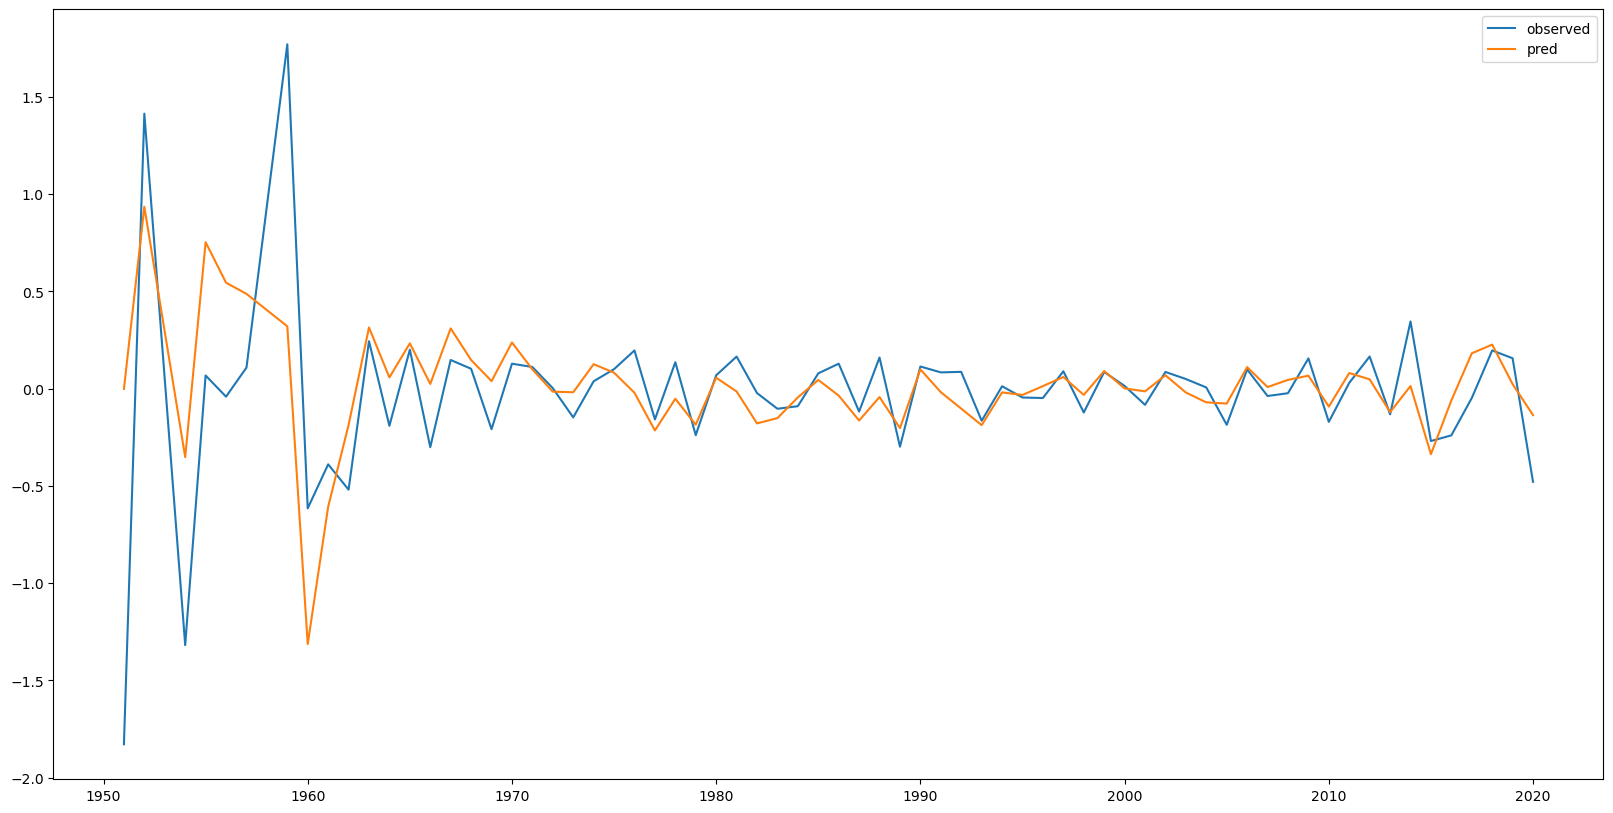

In [53]:
y_pred = ma_model.predict()

fig, ax = plt.subplots(figsize=(20,10)) 
ax.plot(y_diff, label='observed')
ax.plot(y_pred, label='pred')
ax.legend();

In [45]:
all_regions = pd.read_csv("LivingPlanetIndex_2022_PublicData/LPD2022_public.csv", dtype='str', index_col=0, header=0)



,Binomial,Replicate,Citation,Class,Order,Family,Genus,Species,Subspecies,Authority,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
ID,,,,,,,,,,,,,,,,,,,,,
1,Balearica_regulorum,1,"Pomeroy, D. and P. Mwima (2002). The State of ...",Aves,Gruiformes,Gruidae,Balearica,regulorum,NaN,"(Bennett, 1834)",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Acrocephalus_sechellensis,1,"Rands, M. (1989). ""Saving the Seychelles brush...",Aves,Passeriformes,Acrocephalidae,Acrocephalus,sechellensis,NaN,"(Oustalet, 1877)",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Copsychus_sechellarum,1,"Komdeur, J. (1996). ""Breeding of the Seychelle...",Aves,Passeriformes,Muscicapidae,Copsychus,sechellarum,NaN,"Newton, 1865",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Copsychus_sechellarum,0,"Komdeur, J. (1996). ""Breeding of the Seychelle...",Aves,Passeriformes,Muscicapidae,Copsychus,sechellarum,NaN,"Newton, 1865",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,Falco_punctatus,0,"Groombridge, J. J., Bruford, M.W., Jones, C.G,...",Aves,Falconiformes,Falconidae,Falco,punctatus,NaN,"Temminck, 1821",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
500003,Platanista_minor,0,WWF (2018) River Dolphin Strategy 2018-2030,Mammalia,Cetacea,Platanistidae,Platanista,minor,NaN,"Owen, 1853",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8,NaN,NaN
500004,Platanista_minor,0,"Chaudhry, A.A., Maan, A.M., Akbar, M., 1999. C...",Mammalia,Cetacea,Platanistidae,Platanista,minor,NaN,"Owen, 1853",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
500005,Platanista_minor,0,"Chaudhry, A.A., Maan, A.M., Akbar, M., 1999. C...",Mammalia,Cetacea,Platanistidae,Platanista,minor,NaN,"Owen, 1853",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
